<a href="https://colab.research.google.com/github/DonnaVakalis/forecasting-MRT-gap/blob/main/model/model_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PREAMBLE (ABOUT THIS NOTEBOOK)

This notebook applies data prediction with Keras LSTM model in Python, on time series (hourly) weather data to predict daily thermal comfort exceedances indoors (e.g., when it gets too hot, and by how much). This can help determine how much cooling is needed (in terms of mean radiant temperature or MRT), and ultimately help decide on which cooling technologies are feasible and most carbon efficient.

# IMPORTS

In [1]:
import os
from google.colab import drive
import pickle
import glob
import numpy as np
import pandas as pd
 
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf

from keras.models import Sequential
from keras.layers import Dense,LSTM,Dropout

# LOAD THE DATA

The training and testing datasets were pre-processed in a separate notebook saved as separate pickles for 2015,2016 and 2017 (and separated by training and test and output variables based on a prior project) in this public repository:

https://github.com/eta-lab/forecasting-comfort

Details about methods from this project can be found here: Rysanek, A., Nuttall, R., McCarty, J, (2021). Forecasting the impact of climate change on thermal comfort using a weighted ensemble of supervised learning models. Building & Environment.

In [2]:
# Point to the folder for this project (forecasting-MRT-gap/data)
drive.mount('/content/gdrive')
DATA_PATH = "/content/gdrive/My Drive/Colab Notebooks/forecasting-MRT-gap/data"

Mounted at /content/gdrive


For each year 2015,2016,2017, examine temperature data (outdoor) and prepare to remerge training/test sets (for dynamically selecting training/testing sets from whole)

(5781, 51) (4407, 51) (1374, 51)


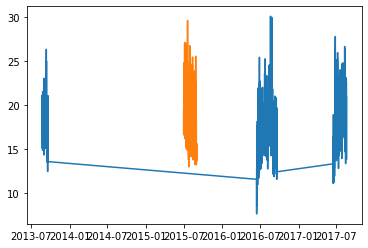

In [26]:
# 2015
dat_train = pickle.load(open(DATA_PATH +'/trainX_2015.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2015.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(5739, 51) (4417, 51) (1322, 51)


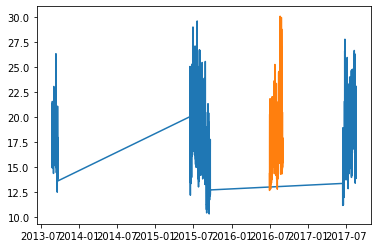

In [25]:
# 2016
dat_train = pickle.load(open(DATA_PATH +'/trainX_2016.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2016.pkl','rb'))

# check if 2015 train and test set are the same
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

(6579, 51) (5028, 51) (1551, 51)


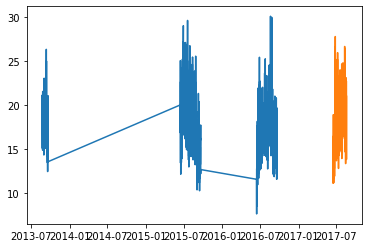

In [27]:
# 2017
dat_train = pickle.load(open(DATA_PATH +'/trainX_2017.pkl','rb'))
dat_test = pickle.load(open(DATA_PATH +'/testX_2017.pkl','rb'))

# check if train and test set are the same, and visualize temp values
df_diff = pd.concat([dat_train,dat_test]).drop_duplicates(keep=False)
print(df_diff.shape, dat_train.shape, dat_test.shape)
df_train = dat_train[['temp']]
df_test = dat_test[['temp']]
plt.plot(df_train.index, df_train.temp, df_test .index, df_test .temp)
plt.show() 

In [18]:
df3 = df1.merge(df2, left_index=True, right_index=True, how='outer')

df3

#plt.plot(df3.index, df3.temp)
#plt.show() 


,temp_x,temp_y
2015-07-01 00:00:00,19.375,19.375
2015-07-01 01:00:00,18.875,18.875
2015-07-01 02:00:00,18.275,18.275
2015-07-01 03:00:00,17.875,17.875
2015-07-01 04:00:00,17.325,17.325
...,...,...
2015-09-01 19:00:00,13.825,13.825
2015-09-01 20:00:00,13.875,13.875
2015-09-01 21:00:00,13.700,13.700
2015-09-01 22:00:00,13.900,13.900


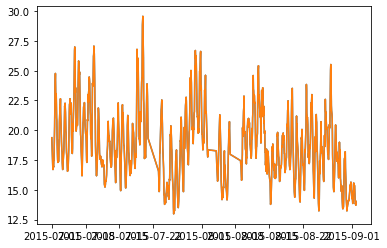

In [11]:
#2015 indoor air temp (what we want to predict)

Y_2015 = pickle.load(open(DATA_PATH +'/testX_2015.pkl','rb'))

Remove smoke-affected days = record incidences of regional forest fires.

These are respectively the first two weeks of July 2015 and the first two weeks of August 2017

In [4]:
testX_2015

,solar_radiation,temp,wind_dir,hum_ratio,windspeed,weekday,week,last_solar_radiation_1,last_solar_radiation_2,last_solar_radiation_3,last_solar_radiation_4,last_solar_radiation_5,last_solar_radiation_6,last_temp_1,last_temp_2,last_temp_3,last_temp_4,last_temp_5,last_temp_6,last_temp_7,last_temp_8,last_temp_9,last_temp_10,last_temp_11,last_temp_12,last_temp_13,last_temp_14,last_temp_15,last_temp_16,last_temp_17,last_temp_18,last_temp_19,last_temp_20,last_temp_21,last_temp_22,last_temp_23,last_temp_24,next_temp_1,next_temp_2,last_wind_dir_1,last_wind_dir_2,last_wind_dir_3,last_wind_dir_4,next_wind_dir_1,next_wind_dir_2,last_hum_ratio_1,last_hum_ratio_2,last_hum_ratio_3,last_hum_ratio_4,last_windspeed_1,last_windspeed_2
2015-07-01 00:00:00,0.00,19.375,281.250,0.011370,7.20,0.0,27.0,0.00,0.00,8.00,84.75,238.75,388.25,20.025,20.850,21.825,22.425,23.175,23.950,24.050,23.000,23.900,21.925,20.725,20.475,21.100,22.850,22.250,21.075,19.125,17.675,17.700,18.600,18.700,19.675,20.525,21.100,18.875,18.275,225.000,281.250,270.000,264.375,286.875,275.625,0.011777,0.012180,0.011726,0.012095,3.87,4.41
2015-07-01 01:00:00,0.00,18.875,286.875,0.010538,10.08,0.0,27.0,0.00,0.00,0.00,8.00,84.75,238.75,19.375,20.025,20.850,21.825,22.425,23.175,23.950,24.050,23.000,23.900,21.925,20.725,20.475,21.100,22.850,22.250,21.075,19.125,17.675,17.700,18.600,18.700,19.675,20.525,18.275,17.875,281.250,225.000,281.250,270.000,275.625,275.625,0.011370,0.011777,0.012180,0.011726,7.20,3.87
2015-07-01 02:00:00,0.00,18.275,275.625,0.010303,9.63,0.0,27.0,0.00,0.00,0.00,0.00,8.00,84.75,18.875,19.375,20.025,20.850,21.825,22.425,23.175,23.950,24.050,23.000,23.900,21.925,20.725,20.475,21.100,22.850,22.250,21.075,19.125,17.675,17.700,18.600,18.700,19.675,17.875,17.325,286.875,281.250,225.000,281.250,275.625,292.500,0.010538,0.011370,0.011777,0.012180,10.08,7.20
2015-07-01 03:00:00,0.00,17.875,275.625,0.010264,11.25,0.0,27.0,0.00,0.00,0.00,0.00,0.00,8.00,18.275,18.875,19.375,20.025,20.850,21.825,22.425,23.175,23.950,24.050,23.000,23.900,21.925,20.725,20.475,21.100,22.850,22.250,21.075,19.125,17.675,17.700,18.600,18.700,17.325,16.850,275.625,286.875,281.250,225.000,292.500,292.500,0.010303,0.010538,0.011370,0.011777,9.63,10.08
2015-07-01 04:00:00,0.00,17.325,292.500,0.010213,12.06,0.0,27.0,0.00,0.00,0.00,0.00,0.00,0.00,17.875,18.275,18.875,19.375,20.025,20.850,21.825,22.425,23.175,23.950,24.050,23.000,23.900,21.925,20.725,20.475,21.100,22.850,22.250,21.075,19.125,17.675,17.700,18.600,16.850,16.700,275.625,275.625,286.875,281.250,292.500,275.625,0.010264,0.010303,0.010538,0.011370,11.25,9.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-09-01 19:00:00,12.25,13.825,106.875,0.009251,6.75,0.0,36.0,26.00,16.75,28.75,109.75,186.50,215.25,14.100,14.450,15.050,15.350,15.375,14.850,14.800,15.575,15.425,15.025,14.400,14.100,13.850,14.175,14.400,14.250,14.450,14.650,14.925,14.975,15.475,15.650,15.550,15.275,13.875,13.700,101.250,112.500,129.375,129.375,135.000,129.375,0.009189,0.008959,0.008857,0.009031,6.84,6.75
2015-09-01 20:00:00,0.00,13.875,135.000,0.008859,8.82,0.0,36.0,12.25,26.00,16.75,28.75,109.75,186.50,13.825,14.100,14.450,15.050,15.350,15.375,14.850,14.800,15.575,15.425,15.025,14.400,14.100,13.850,14.175,14.400,14.250,14.450,14.650,14.925,14.975,15.475,15.650,15.550,13.700,13.900,106.875,101.250,112.500,129.375,129.375,135.000,0.009251,0.009189,0.008959,0.008857,6.75,6.84
2015-09-01 21:00:00,0.00,13.700,129.375,0.008757,4.41,0.0,36.0,0.00,12.25,26.00,16.75,28.75,109.75,13.875,13.825,14.100,14.450,15.050,15.350,15.375,14.850,14.800,15.575,15.425,15.025,14.400,14.100,13.850,14.175,14.400,14.250,14.450,14.650,14.925,14.975,15.475,15.650,13.900,14.025,135.000,106.875,101.250,112.500,135.000,168.750,0.008859,0.009251,0.009189,0.008959,8.82,6.75
2015-09-01 22:00:00,0.00,13.900,135.000,0.008547,5.13,0.0,36.0,0.00,0.00,1

In [ ]:
# Drop times that are either off-season (e.g., winter) or during fire smoke events
